<a href="https://colab.research.google.com/github/olufunmiruth/KubeflowTraining/blob/master/Copy_of_mnist_minio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Pipeline with Mnist Dataset

## Introduction
[Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/) helps with building entire workflows

These steps can be triggered automatically by a CI/CD workflow or on demand from a command line or notebook.


**Components** performs a single step in a Machine Learning workflow such (e.g. data ingestion, data preprocessing, data transformation, model training, hyperparameter tuning). 

**Dataset**: The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available in Tenserflow Datasets. The digits have been size-normalized and centered in a fixed-size image.

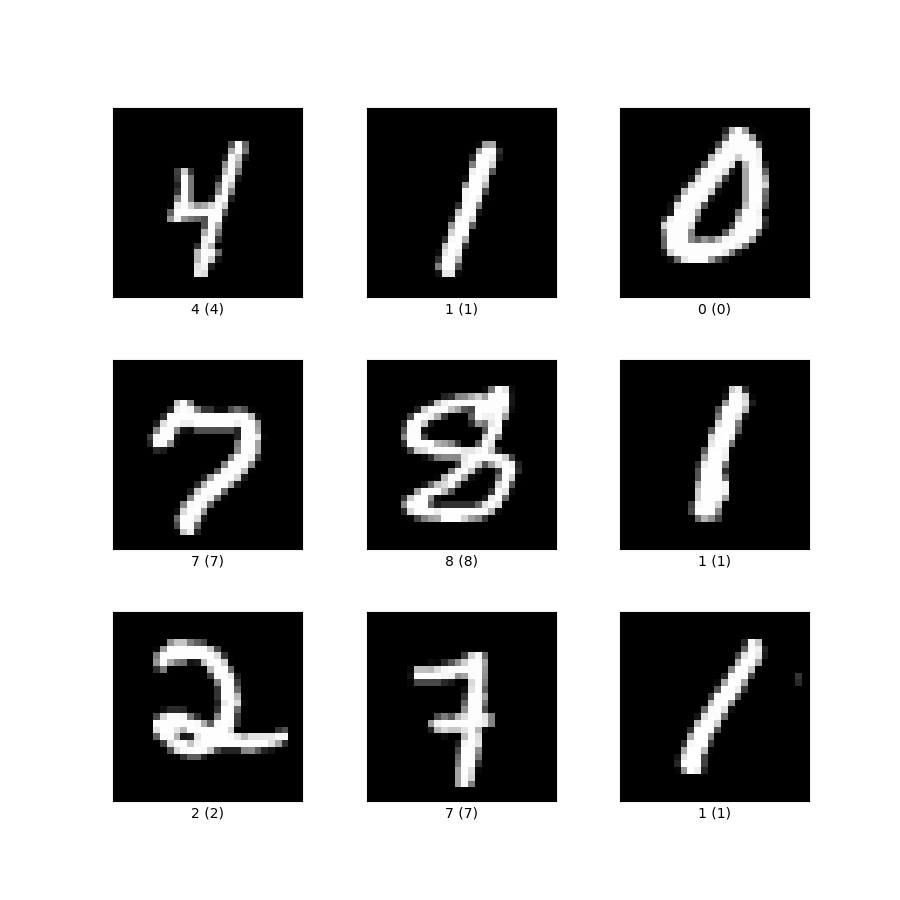
## Prerequisites
check to see if kfp is installed:

In [ ]:
! pip3 show kfp

## 1. Configure access Minio 

### Upload our Training Dataset to Minio

First, we configure credentials for `mc`, the MinIO command line client.
We then use it to create a bucket, upload the dataset to it, and set access policy so that the pipeline can download it from MinIO.

Follow the steps below to download minio client
<div class="alert">
   <code>
    wget https://dl.min.io/client/mc/release/linux-amd64/mc
    chmod +x mc
    ./mc --help
    </code>

</div>

In [ ]:
! wget https://dl.min.io/client/mc/release/linux-amd64/mc
! chmod +x mc
! ./mc --help

#### a. Connect to the Minio Server

In [ ]:
! ./mc alias set minio http://minio-service.kubeflow:9000 minio minio123

#### b. Create a bucket to stor your data and export your model to Minio

**Make sure you clear this bucket once you are cone running your pipeline**

In [ ]:
! ./mc mb minio/mnist

#### c. Upload the dataset to your bucket in Minio.

**Note**: Make sure you have your dataset in a folder like we have here as <code>datasets</code>.

In [ ]:
! tar --dereference -czf datasets.tar.gz ./datasets
! ./mc cp datasets.tar.gz minio/mnist/datasets.tar.gz
! ./mc policy set download minio/mnist

### If you have downloaded your data too many times while testing, use the following code to clear out your bucket

In [ ]:
# ! ./mc rm --recursive --force minio/mnist

### Minio Server URL and Credentials

In [ ]:
MINIO_SERVER='minio-service.kubeflow:9000'
MINIO_ACCESS_KEY='minio'
MINIO_SECRET_KEY='minio123'

## How to Implement Kubeflow Pipelines Components

In this pipeline, we have the following components:
- MNIST dataset download component
- Train the TensorFlow model
- Evaluate the trained model
- Export the trained model

In [ ]:
from typing import NamedTuple
import kfp
import kfp.components as components
import kfp.dsl as dsl
from kfp.components import InputPath, OutputPath #helps define the input & output between the components

### Component 1: Download the MNIST Data Set

In [ ]:
def download_dataset(minio_server: str, data_dir: OutputPath(str)):
    """Download the MNIST data set to the KFP volume to share it among all steps"""
    import urllib.request
    import tarfile
    import os
    import subprocess

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        
    #this url leads to your bucket
    url = f'http://{minio_server}/mnist/datasets.tar.gz'
    stream = urllib.request.urlopen(url)
    tar = tarfile.open(fileobj=stream, mode="r|gz")
    tar.extractall(path=data_dir)
    
    subprocess.call(["ls", "-lha", data_dir])

### Component 2: Train the Model
For both the training and evaluation we must divide the integer-valued pixel values by 255 to scale all values into the [0, 1] (floating-point) range.

In [ ]:
def train_model(data_dir: InputPath(str), model_dir: OutputPath(str)):
    """Trains a single-layer CNN for 5 epochs using a pre-downloaded dataset.
    Once trained, the model is persisted to `model_dir`."""

    import os
    import tensorflow as tf
    import tensorflow_datasets as tfds

    def normalize_image(image, label):
        """Normalizes images: `uint8` -> `float32`"""
        return tf.cast(image, tf.float32) / 255.0, label

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(0.001),
        metrics=["accuracy"],
    )


    print(model.summary())
    ds_train, ds_info = tfds.load(
        "mnist",
        split="train",
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
        download=True,
        data_dir=f"{data_dir}/datasets",
    )

    ds_train = ds_train.map(
        normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
    ds_train = ds_train.batch(128)
    ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

    model.fit(
        ds_train,
        epochs=5,
    )

    model.save(model_dir)
    print(f"Model saved {model_dir}")
    print(os.listdir(model_dir))

### Component 3: Evaluate the Model
With the following Python function the model is evaluated.
The metrics [metadata](https://www.kubeflow.org/docs/pipelines/sdk/pipelines-metrics/) (loss and accuracy) is available to the Kubeflow Pipelines UI.
Metadata can automatically be visualized with output viewer(s).
Please go [here](https://www.kubeflow.org/docs/pipelines/sdk/output-viewer/) to see how to do that.

In [ ]:
def evaluate_model(
    data_dir: InputPath(str), model_dir: InputPath(str), metrics_path: OutputPath(str)
) -> NamedTuple("EvaluationOutput", [("mlpipeline_metrics", "Metrics")]):
    """Loads a saved model from file and uses a pre-downloaded dataset for evaluation.
    Model metrics are persisted to `/mlpipeline-metrics.json` for Kubeflow Pipelines
    metadata."""

    import json
    import tensorflow as tf
    import tensorflow_datasets as tfds
    from collections import namedtuple

    def normalize_image(image, label):
        return tf.cast(image, tf.float32) / 255.0, label

    ds_test, ds_info = tfds.load(
        "mnist",
        split="test",
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
        download=True,
        data_dir=f"{data_dir}/datasets",
    )

    ds_test = ds_test.map(
        normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds_test = ds_test.batch(128)
    ds_test = ds_test.cache()
    ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

    model = tf.keras.models.load_model(model_dir)
    (loss, accuracy) = model.evaluate(ds_test)

    metrics = {
        "metrics": [
            {"name": "loss", "numberValue": str(loss), "format": "PERCENTAGE"},
            {"name": "accuracy", "numberValue": str(accuracy), "format": "PERCENTAGE"},
        ]
    }

    with open(metrics_path, "w") as f:
        json.dump(metrics, f)

    out_tuple = namedtuple("EvaluationOutput", ["mlpipeline_metrics"])

    return out_tuple(json.dumps(metrics))

### Component 4: Export the Model

In [ ]:
def export_model(
    model_dir: InputPath(str),
    metrics: InputPath(str),
    export_bucket: str,
    model_name: str,
    model_version: int,
    minio_server: str,
    minio_access_key: str,
    minio_secret_key: str,
):
    import os
    import boto3
    from botocore.client import Config
    

    s3 = boto3.client(
        "s3",
        endpoint_url=f'http://{minio_server}',
        aws_access_key_id=minio_access_key,
        aws_secret_access_key=minio_secret_key,
        config=Config(signature_version="s3v4"),
    )

    # Create export bucket if it does not yet exist
    response = s3.list_buckets()
    export_bucket_exists = False

    print(response , export_bucket)
    for bucket in response["Buckets"]:
        if bucket["Name"] == export_bucket:
            export_bucket_exists = True

    if not export_bucket_exists:
        s3.create_bucket(ACL="public-read-write", Bucket=export_bucket)

    # Save model files to S3
    for root, dirs, files in os.walk(model_dir):
        for filename in files:
            local_path = os.path.join(root, filename)
            s3_path = os.path.relpath(local_path, model_dir)

            s3.upload_file(
                local_path,
                export_bucket,
                f"{model_name}/{model_version}/{s3_path}",
                ExtraArgs={"ACL": "public-read"},
            )

    response = s3.list_objects(Bucket=export_bucket)
    print(f"All objects in {export_bucket}:")
    for file in response["Contents"]:
        print("{}/{}".format(export_bucket, file["Key"]))

## How to Combine the Components into a Pipeline
Note that up to this point we have not yet used the Kubeflow Pipelines SDK!

With our four components (i.e. self-contained functions) defined, we can wire up the dependencies with Kubeflow Pipelines.

The call [`components.func_to_container_op(f, base_image=img)(*args)`](https://www.kubeflow.org/docs/pipelines/sdk/sdk-overview/) has the following ingredients:
- `f` is the Python function that defines a component
- `img` is the base (Docker) image used to package the function
- `*args` lists the arguments to `f`

What the `*args` mean is best explained by going forward through the graph:
- `downloadOp` is the very first step and has no dependencies; it therefore has no `InputPath`.
  Its output (i.e. `OutputPath`) is stored in `data_dir`.
- `trainOp` needs the data downloaded from `downloadOp` and its signature lists `data_dir` (input) and `model_dir` (output).
  So, it _depends on_ `downloadOp.output` (i.e. the previous step's output) and stores its own outputs in `model_dir`, which can be used by another step.
  `downloadOp` is the parent of `trainOp`, as required.
- `evaluateOp`'s function takes three arguments: `data_dir` (i.e. `downloadOp.output`), `model_dir` (i.e. `trainOp.output`), and `metrics_path`, which is where the function stores its evaluation metrics.
  That way, `evaluateOp` can only run after the successful completion of both `downloadOp` and `trainOp`.
- `exportOp` runs the function `export_model`, which accepts five parameters: `model_dir`, `metrics`, `export_bucket`, `model_name`, and `model_version`.
  From where do we get the `model_dir`?
  It is nothing but `trainOp.output`.
  Similarly, `metrics` is `evaluateOp.output`.
  The remaining three arguments are regular Python arguments that are static for the pipeline: they do not depend on any step's output being available.
  Hence, they are defined without using `InputPath`.

In [ ]:
def train_model_pipeline(
    data_dir: str,
    model_dir: str,
    export_bucket: str,
    model_name: str,
    model_version: int,
    minio_server: str,
    minio_access_key: str,
    minio_secret_key: str,
):
    # For GPU support, please add the "-gpu" suffix to the base image
    BASE_IMAGE = "mavencodev/minio:v.0.1"

    downloadOp = components.func_to_container_op(
        download_dataset, base_image=BASE_IMAGE
    )(minio_server)

    trainOp = components.func_to_container_op(train_model, base_image=BASE_IMAGE)(
        downloadOp.output
    )

    evaluateOp = components.func_to_container_op(evaluate_model, base_image=BASE_IMAGE)(
        downloadOp.output, trainOp.output
    )

    exportOp = components.func_to_container_op(export_model, base_image=BASE_IMAGE)(
        trainOp.output, evaluateOp.output, export_bucket, 
        model_name, model_version, minio_server, minio_access_key, minio_secret_key
    )


Just in case it isn't obvious: this will build the Docker images for you.
Each image is based on `BASE_IMAGE` and includes the Python functions as executable files.
Each component _can_ use a different base image though.
This may come in handy if you want to have reusable components for automatic data and/or model analysis (e.g. to investigate bias).

We still have to define the pipeline itself.
Our `train_and_export` function defines dependencies but we must use the KFP domain-specific language (DSL) to register the pipeline with its components:

In [ ]:

def op_transformer(op):
    op.add_pod_annotation(name="sidecar.istio.io/inject", value="false")
    return op


@dsl.pipeline(
    name="End-to-End MNIST Pipeline",
    description="A sample pipeline to demonstrate multi-step model training, evaluation and export",
)
def mnist_pipeline(
    model_dir: str = "/train/model",
    data_dir: str = "/train/data",
    export_bucket: str = "mnist",
    model_name: str = "mnist",
    model_version: int = 1,
):
    MINIO_SERVER='minio-service.kubeflow:9000'
    MINIO_ACCESS_KEY='minio'
    MINIO_SECRET_KEY='minio123'
    
    
    train_model_pipeline(
        data_dir=data_dir,
        model_dir=model_dir,
        export_bucket=export_bucket,
        model_name=model_name,
        model_version=model_version,
        minio_server=MINIO_SERVER,
        minio_access_key=MINIO_ACCESS_KEY,
        minio_secret_key=MINIO_SECRET_KEY,
    )
    
    dsl.get_pipeline_conf().add_op_transformer(op_transformer)

With that in place, let's submit the pipeline directly from our notebook:

In [ ]:
pipeline_func = mnist_pipeline
run_name = pipeline_func.__name__ + " run"
experiment_name = "End-to-End-Demo"

kfp.compiler.Compiler().compile(pipeline_func,  'mnist.yaml')
    

#### Upload the generated yaml file to create a pipeline in Kubeflow UI

##### Now delete your bucket when you have run the pipeline successfully in the Kubeflow UI.

In [ ]:
# ! ./mc rb minio/mnist --force